In [31]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import glob
import datetime
import scipy.io
import numpy as np
import seaborn as sb
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap, cm, addcyclic
% matplotlib inline

In [2]:
import seawater as sw
from ArcticTools import map
from ArcticTools import hovmoller as hov
from ArcticTools import Topostrophy_sepecific_layer as Ts

In [3]:
mesh=nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc')
e1t= mesh.variables['e1t'][0,400:,:]  # dx
e2t= mesh.variables['e2t'][0,400:,:]  # dy 
e3t= mesh.variables['e3t'][0,:]
tmask= mesh.variables['tmask'][0,:,400:,:]
dep = mesh.variables['gdept_0'][0.,:]

bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]

In [4]:
nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/min_ice/nasaRun/Y*2008*.nc'))#*_ptrc_T*.nc'))
print("found *.nc file: \n{}".format(nc_filename))
ptrc=nc.Dataset(nc_filename[0])
nav_lon=ptrc.variables['nav_lon'][:,:]
nav_lat=ptrc.variables['nav_lat'][:,:]

found *.nc file: 
['/ocean/xiaoxiny/research/result_jasper/min_ice/nasaRun/Y19682008.nc']


In [5]:
dfield_dx = np.zeros((2,bathy.shape[0],bathy.shape[1]))
dfield_dx.shape

(2, 400, 544)

In [6]:
# grid for plotting
x1d=np.linspace(0,nav_lon[:,0].shape[0],nav_lat[:,0].shape[0])
y1d=np.linspace(0,nav_lon[0,:].shape[0],nav_lat[0,:].shape[0])
x2d,y2d=np.meshgrid(y1d,x1d)

In [7]:
def load_v(vel_comp,T, tmask, ENG, key ):
    '''
    This function is designed to obtain velocity field
    ======================================================
    '''
    vels ={'U':'vozocrtx','V':'vomecrty','W':'vovecrtz'}

    with nc.Dataset(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*%s*%s.nc'%(ENG,vel_comp,T))[0])\
as temp:
        data  = temp.variables[vels[vel_comp]][0,:,400:,:]
    #data  = np.ma.masked_where(tmask == 0,data)
    return data

In [8]:
def roate(orig_xcomp,orig_ycomp, xslope,yslope):
    '''
    orig_ycomp: can be v/ or flux in y direction
    orig_xcomp: can be u/ or flux in x direction
    '''
    z = (yslope**2 + xslope**2)**0.5
    # orig componant --> cross-section 
    cr_comp =-orig_xcomp*yslope/z + orig_ycomp*xslope/z
    # orig componant --> Along-section 
    al_comp = orig_xcomp*xslope/z + orig_ycomp*yslope/z
    return cr_comp,al_comp

def gradient(Pressure, rotate ='False'):
    '''    
    ug = -dP_y/(f*rho)
    vg = dP_x/(f*rho)
    This function calculate dP_dx, dP_dy
    '''
    dP = d_(Pressure);
    dx = e1t;
    dy = e2t;
    dP_x = dP[0,:]/dx;
    dP_y = dP[1,:]/dy;
    return dP_x, dP_y

def d_(field):
    '''    
    ug = -dP_y/(f*rho)
    vg = dP_x/(f*rho)
    In order to calculate dP_dx, dP_dy, we need dP. This function does this job.
    '''
    dfield= np.zeros((2,field.shape[0],field.shape[1],field.shape[2]))
    for i in range (field.shape[0]):
        # dx
        dfield[0,i,:, :-1] = field[i,:, 1:]-field[i,:, :-1]
        dfield[0,i,:,-1] = dfield[0,i,:,-2] # assuming the last two columns have the same dx (and dy)
        # dy
        dfield[1,i,:-1, :] = field[i,1:, :]-field[i,:-1, :]
        dfield[1,i,-1,:] = dfield[1,i,-2,:]
    return dfield

In [20]:
mbathy=nc.Dataset(
        '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc').variables['mbathy'][0,400:,:]

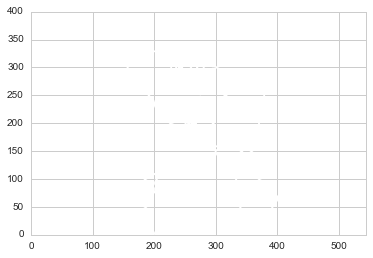

In [21]:
x1d=np.linspace(0,mbathy[:,0].shape[0],mbathy[:,0].shape[0])
y1d=np.linspace(0,mbathy[0,:].shape[0],mbathy[0,:].shape[0])
#x2d,y2d=np.meshgrid(y1d,x1d)

cs=plt.contour(y1d,x1d,mbathy[:,:],[38])
p = cs.collections[0].get_paths()[2]
v = p.vertices
y = v[:,0]
x = v[:,1]

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  from ipykernel import kernelapp as app
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  app.launch_new_instance()


(100, 450)

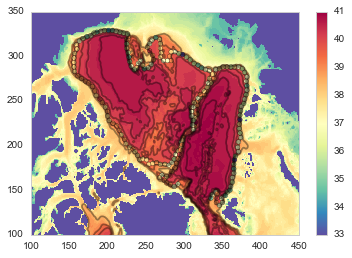

In [22]:
plt.pcolor(y1d,x1d,mbathy,cmap = 'Spectral_r')
plt.contour(y1d,x1d,bathy,linewidth=0.075,colors='black',alpha=0.4,\
            vmin = -1,vmax =mbathy[np.round(x[200:-300:5]).tolist(),np.round(y[200:-300:5]).tolist()].max() )
plt.scatter(np.round(y[200:-300:5]),np.round(x[200:-300:5]),\
            c=mbathy[np.round(x[200:-300:5]).tolist(),np.round(y[200:-300:5]).tolist()],\
            cmap = 'Spectral_r')
plt.colorbar()
plt.ylim([100,350])
plt.xlim([100,450])

In [23]:
xtest = np.copy(x)
ytest = np.copy(y)

k = 0
for i in range (0,len(x[200:-300]),5):    
    if mbathy[np.round(xtest[200+i]),np.round(ytest[200+i])] <34:
            k +=1
            #print (k)
            for loopi in range (4,0,-1):
                for zo in [-1,1]:
                    px =x[200+i+zo*loopi]
                    py =y[200+i+zo*loopi]
                    if mbathy[np.round(px),np.round(py)] >=34:
                        xtest[200+i] = px
                        ytest[200+i] = py
                        #print ('>> %s: success!'%k)
                    else:
                        px =x[200+i]+zo*loopi
                        py =y[200+i]+zo*loopi
                        if mbathy[np.round(px),np.round(py)] >=34:
                            xtest[200+i] = px
                            ytest[200+i] = py
                            #print ('>> %s: success!'%k)
                    #break
                #break

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  from ipykernel import kernelapp as app


(100, 450)

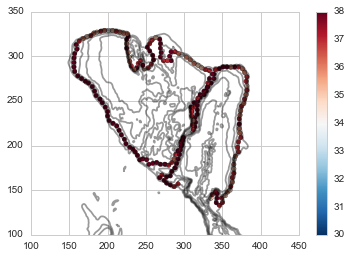

In [24]:
plt.contour(y1d,x1d,bathy,linewidth=0.075,colors='black',alpha=0.4)
plt.scatter(np.round(ytest[200:-300:5]),np.round(xtest[200:-300:5]),\
            c=mbathy[np.round(xtest[200:-300:5]).tolist(),\
                     np.round(ytest[200:-300:5]).tolist()],\
            cmap = 'RdBu_r',vmin = 30,vmax=38)

plt.colorbar()
#plt.scatter(np.round(ytest[200:-300:250]),np.round(xtest[200:-300:250]),\
#        c='r',s=50)
#plt.scatter(np.round(ytest[200+630]),np.round(xtest[200+630]),\
#        c='gold',s=50)
plt.ylim([100,350])
plt.xlim([100,450])

In [25]:
a=np.round(xtest[0:-300:2]).tolist()
b=np.round(ytest[0:-300:2]).tolist()

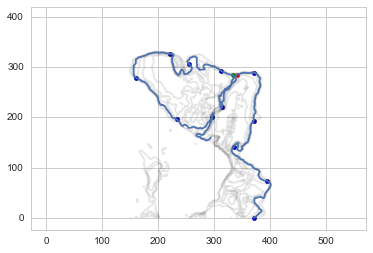

In [26]:
plt.contour(y1d,x1d,bathy,linewidth=0.075,colors='black',alpha=0.1)
plt.plot(b[:],a[:])
plt.scatter(b[::50],a[::50])
plt.scatter(b[115+100],a[115+100],color='r')
plt.scatter(b[190+100],a[190+100],color='g')

In [27]:
del a[115+100:190+100]

In [28]:
del b[115+100:190+100]

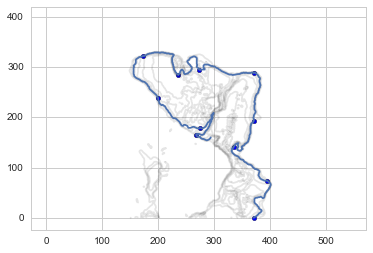

In [29]:
plt.contour(y1d,x1d,bathy,linewidth=0.075,colors='black',alpha=0.1)
plt.plot(b[:],a[:])
plt.scatter(b[::50],a[::50])

bottom water in CB didn't recieve high sal from NB.

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3117: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  dout = self.data[indx]
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3172: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  dout._mask = _mask[indx]
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


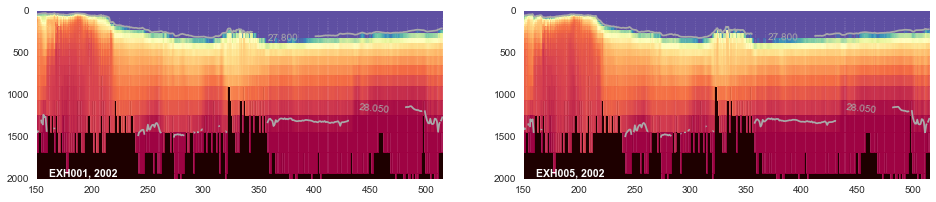

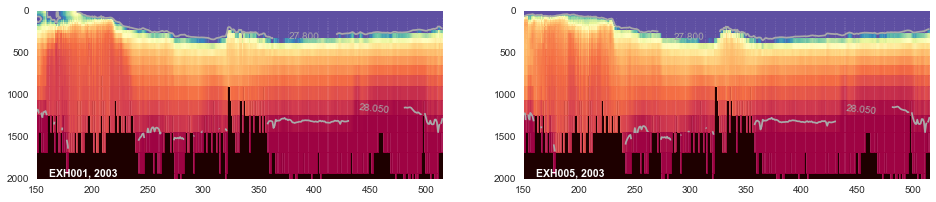

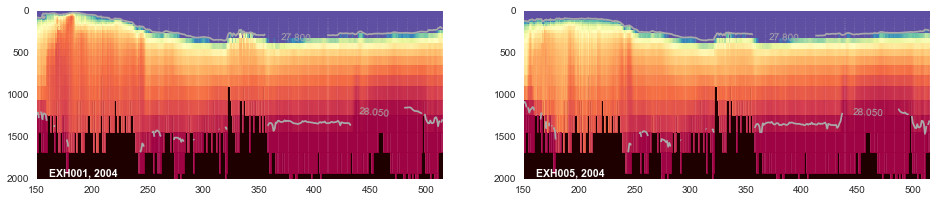

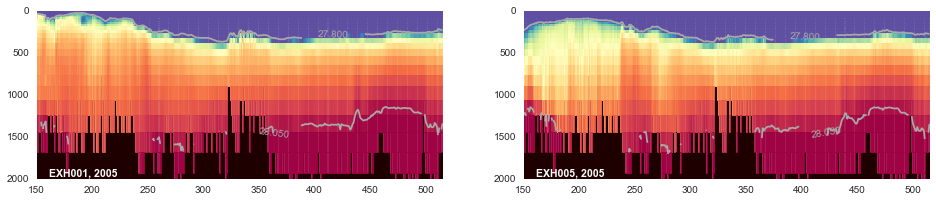

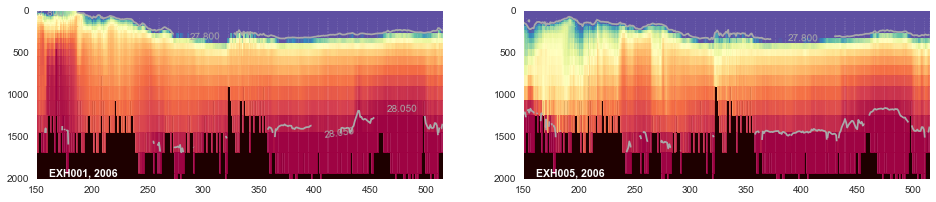

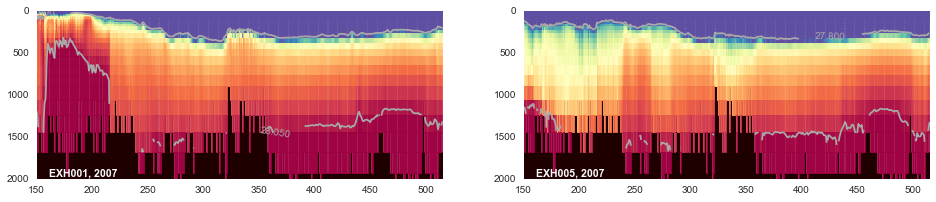

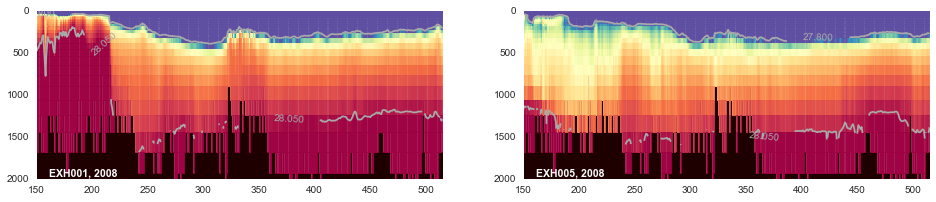

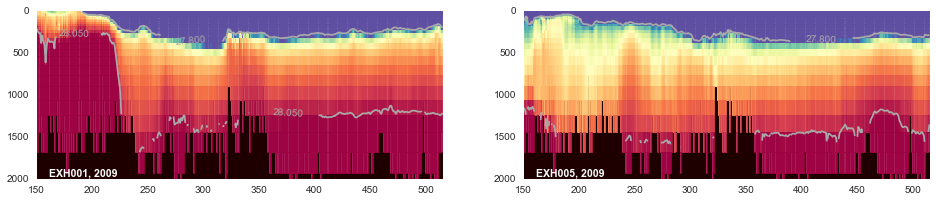

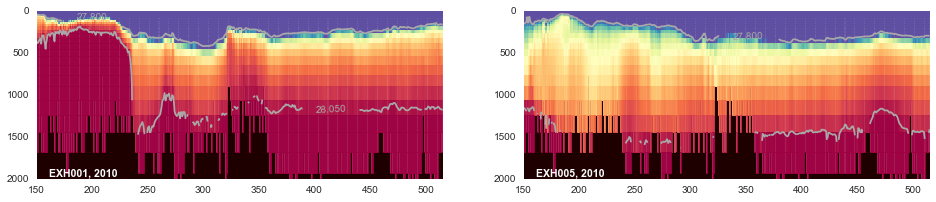

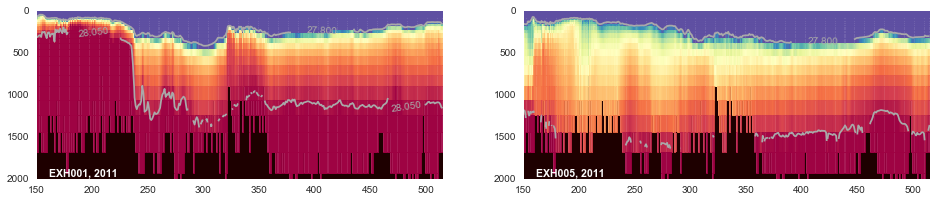

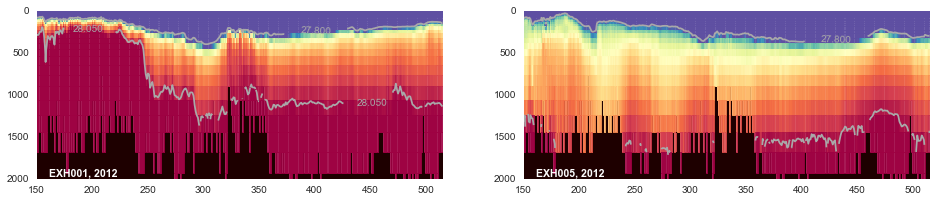

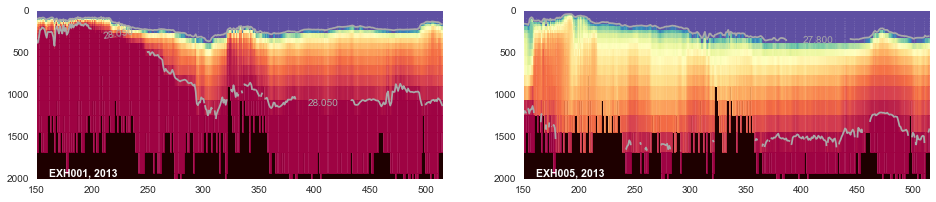

In [142]:
coor=np.linspace(1,len(a),len(a))#x2d[a,b]
iso=[1027.8,1028.05]#1027.8,1028.05]
vlim=[27.8,28.05]

#fig,axes=plt.subplots(3,2,figsize=(12,6))
#for i,axnum in zip([2002,2008,2012],range(3)):
for i in range (2002,2014):
        fig,axes=plt.subplots(1,2,figsize=(16,3))
        temp= hov.load_ts('T',T=i,tmask= tmask, ENG='exh001', key = '_t_')
        sal= hov.load_ts('S',T=i,tmask= tmask, ENG='exh001', key = '_s_')
        t = sw.library.T90conv(temp)
        rho = sw.dens0(sal, t)
        
        #drho_x, drho_y = gradient(rho)
        #drho_x = drho_x[:,a,b]
        

        temp5= hov.load_ts('T',T=i,tmask= tmask, ENG='exh005', key = '_t_')
        sal5= hov.load_ts('S',T=i,tmask= tmask, ENG='exh005', key = '_s_')
        t5 = sw.library.T90conv(temp5)
        rho5 = sw.dens0(sal5, t5)
        #drho5_x, drho5_y = gradient(rho5)
        #drho5_x = drho5_x[:,a,b]

        for ax,title,rho in zip(axes.flat,['EXH001','EXH005'],[rho,rho5]):
                mymask = np.copy(rho[:,a,b])
                data = np.copy(rho[:,a,b])
                #data[:,:-1]=data[:,1:]-data[:,:-1]
                #_, dX = roate(e1t[a,b],e2t[a,b], 1,2)
                #data = data/dX
                mymask[tmask[:,a,b] == 0] = -1
                ax.pcolor(coor,dep[:],mymask,vmin= -1,cmap= 'pink')
                
                
                data[rho[:,a,b]==0] = np.nan
                #data[rho[:,a,b]<iso[0]] = np.nan
                #data[rho[:,a,b]>iso[-1]] = np.nan
                
                #data[rho[:,a,b] == np.nan]= np.nan
                
                ctour=ax.contour(coor,dep[:],np.ma.masked_invalid(data-1000),np.array(iso)-1000,colors='darkgrey')
                plt.clabel(ctour, inline=1, fontsize=10)
                
                cs=ax.pcolor(coor,dep[:],
                             np.ma.masked_invalid(data-1000),
                             cmap='Spectral_r',vmin = vlim[0],vmax = vlim[1], alpha = 0.9)
                #fig.colorbar(cs,ax=ax)
                ax.set_ylim(0,2000)
                ax.set_xlim(150,coor.max())
                ax.invert_yaxis()
                ax.text(0.2,0.02, '%s, %s'%(title,i), transform=ax.transAxes, 
                        weight = 'bold',ha='right', fontsize=10.5,color='white')

                #plt.tight_layout()
        plt.show()


#cax = fig.add_axes([1.01, 0.1, 0.01, 0.8])
#cbar=fig.colorbar(cs,cax=cax,extend='both')#,format='%.0e')
#cbar.formatter.set_powerlimits((-2, 2))
#cbar.update_ticks()
#cbar.set_label('rho')

#plt.tight_layout()
#plt.show()

# original iso: grey

# current iso: black

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3117: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  dout = self.data[indx]
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3172: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  dout._mas

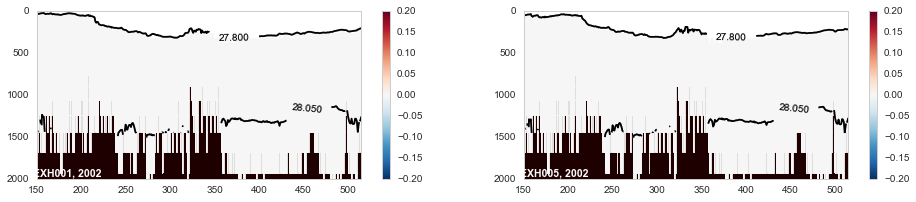

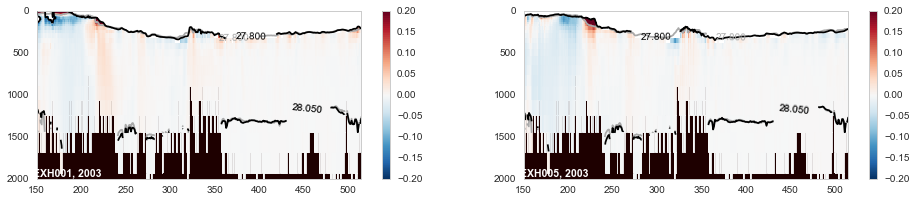

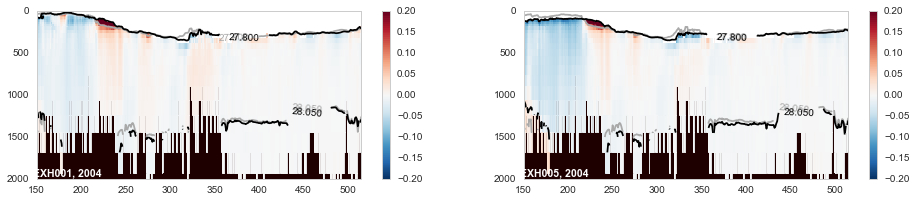

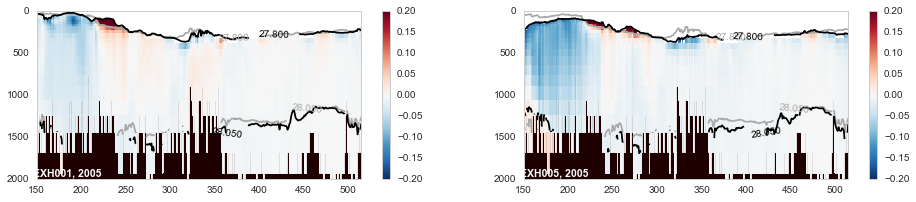

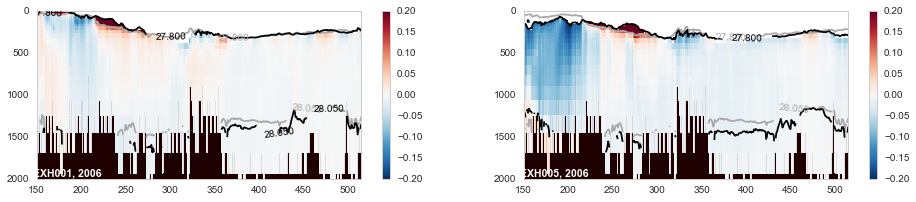

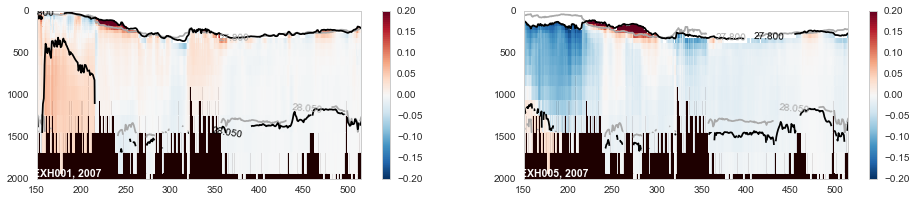

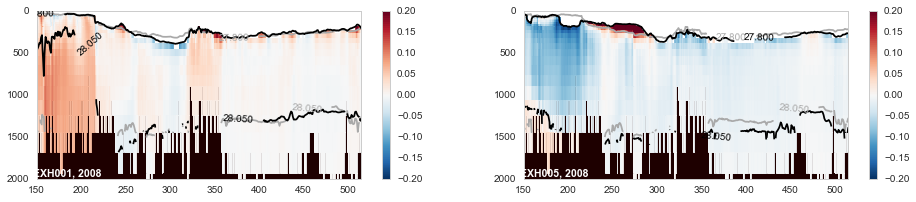

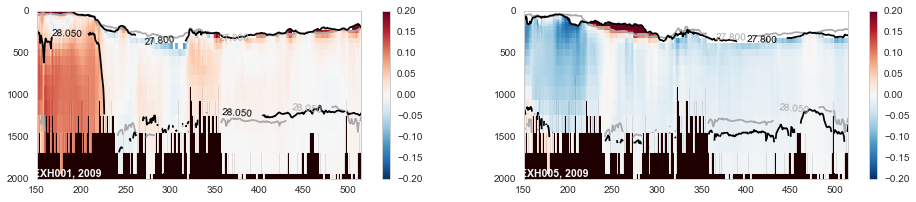

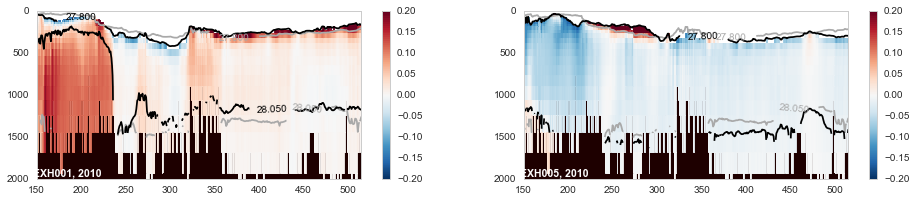

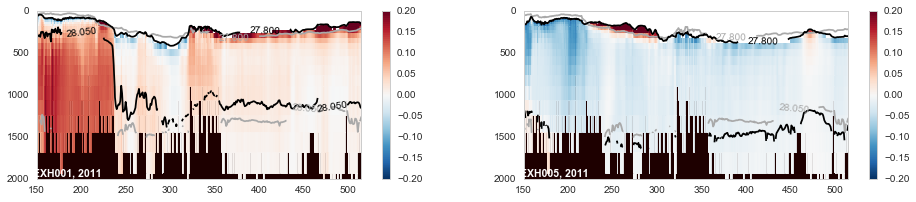

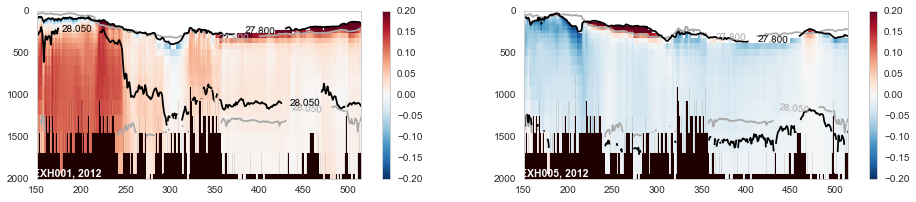

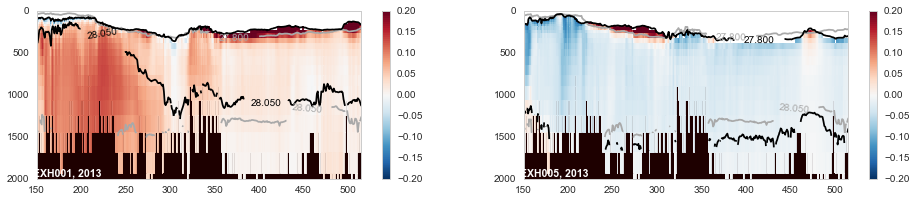

In [45]:
coor=np.linspace(1,len(a),len(a))#x2d[a,b]
iso=[1027.8,1028.05]#1027.8,1028.05]
vlim=[-.2,.2]

#fig,axes=plt.subplots(3,2,figsize=(12,6))
#for i,axnum in zip([2002,2008,2012],range(3)):
for i in range (2002,2014):
        fig,axes=plt.subplots(1,2,figsize=(16,3))
        temp= hov.load_ts('T',T=i,tmask= tmask, ENG='exh001', key = '_t_')
        sal= hov.load_ts('S',T=i,tmask= tmask, ENG='exh001', key = '_s_')
        t = sw.library.T90conv(temp)
        rho = sw.dens0(sal, t)
        

        temp5= hov.load_ts('T',T=i,tmask= tmask, ENG='exh005', key = '_t_')
        sal5= hov.load_ts('S',T=i,tmask= tmask, ENG='exh005', key = '_s_')
        t5 = sw.library.T90conv(temp5)
        rho5 = sw.dens0(sal5, t5)
        if i == 2002:
            base = np.copy(rho)
            base5 = np.copy(rho5)

        for ax,title,rho,rho0 in zip(axes.flat,['EXH001','EXH005'],[rho,rho5],[base,base5]):
            
                mymask = np.copy(rho0[:,a,b])
                data = np.copy(rho0[:,a,b])
                mymask[tmask[:,a,b] == 0] = -1
                ax.pcolor(coor,dep[:],mymask,vmin= -1,cmap= 'pink')                
                data[rho[:,a,b]==0] = np.nan
                ctour=ax.contour(coor,dep[:],np.ma.masked_invalid(data)-1000,np.array(iso)-1000,colors='darkgrey')
                plt.clabel(ctour, inline=1, fontsize=10)
            
            
                mymask = np.copy(rho[:,a,b])
                data = np.copy(rho[:,a,b])
                mymask[tmask[:,a,b] == 0] = -1
                ax.pcolor(coor,dep[:],mymask,vmin= -1,cmap= 'pink')                
                data[rho[:,a,b]==0] = np.nan
                
                ctour=ax.contour(coor,dep[:],np.ma.masked_invalid(data)-1000,np.array(iso)-1000,colors='k')
                plt.clabel(ctour, inline=1, fontsize=10)
                
               
            
                data = np.copy(rho[:,a,b])-rho0[:,a,b]
                mymask[tmask[:,a,b] == 0] = -1
                ax.pcolor(coor,dep[:],mymask,vmin= -1,cmap= 'pink')
                
                
                data[rho[:,a,b]<iso[0]] = np.nan
                cs=ax.pcolor(coor,dep[:],
                             np.ma.masked_invalid(data),
                             cmap='RdBu_r',vmin = vlim[0],vmax = vlim[1], alpha = 0.9)
                fig.colorbar(cs,ax=ax)
                ax.set_ylim(0,2000)
                ax.set_xlim(150,coor.max())
                ax.invert_yaxis()
                ax.text(0.2,0.02, '%s, %s'%(title,i), transform=ax.transAxes, 
                        weight = 'bold',ha='right', fontsize=10.5,color='white')

                #plt.tight_layout()
        plt.show()


#cax = fig.add_axes([1.01, 0.1, 0.01, 0.8])
#cbar=fig.colorbar(cs,cax=cax,extend='both')#,format='%.0e')
#cbar.formatter.set_powerlimits((-2, 2))
#cbar.update_ticks()
#cbar.set_label('rho')

#plt.tight_layout()
#plt.show()

Starting from 0 (Atlantic)

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3117: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  dout = self.data[indx]
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3172: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  dout._mas

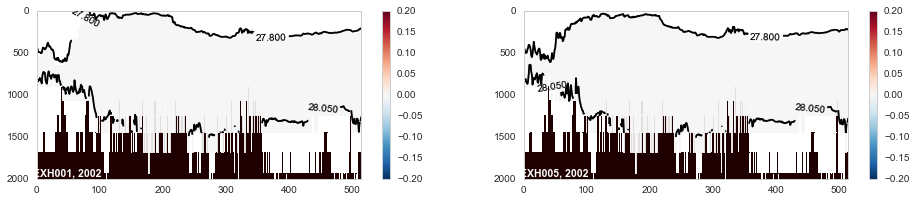

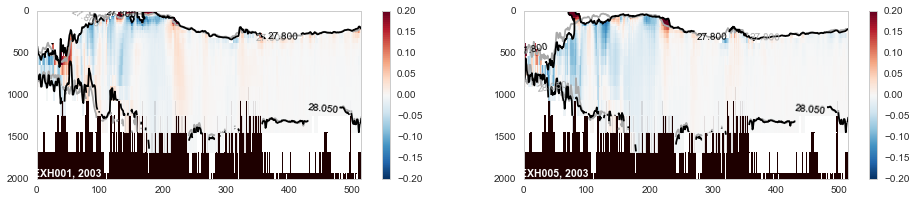

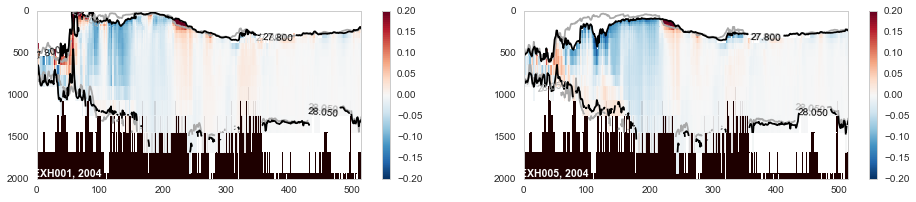

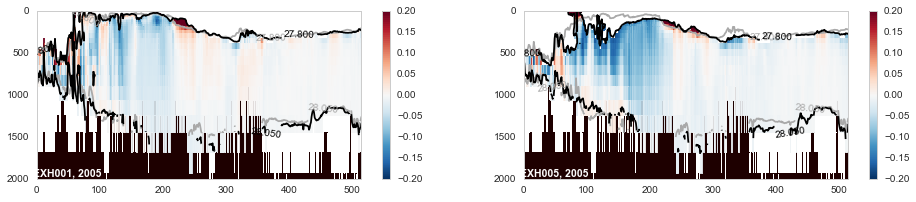

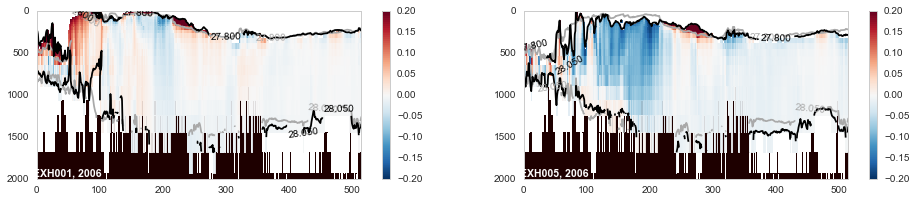

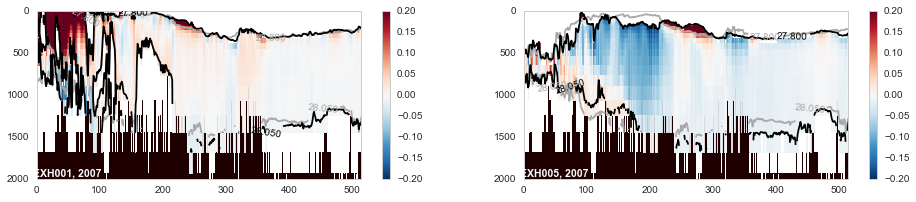

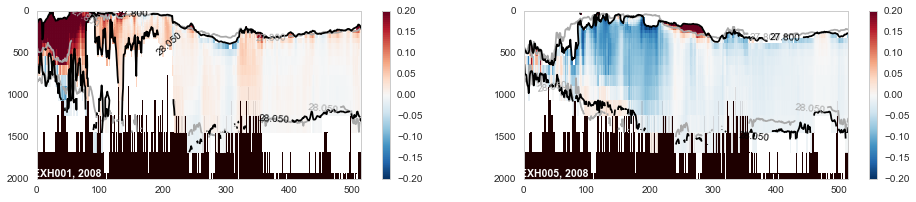

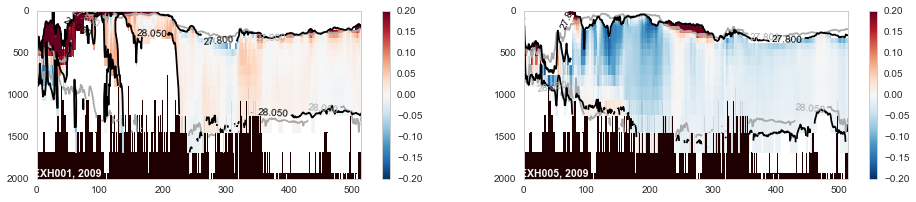

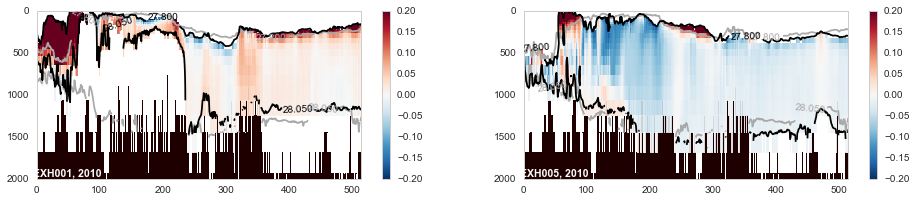

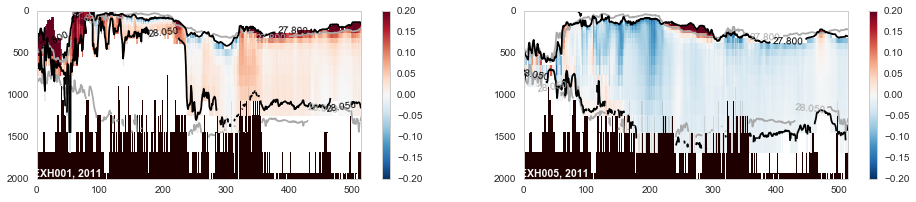

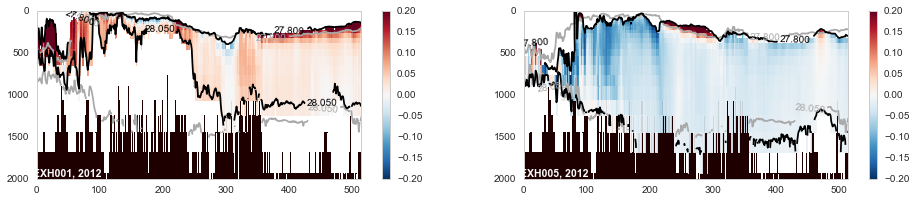

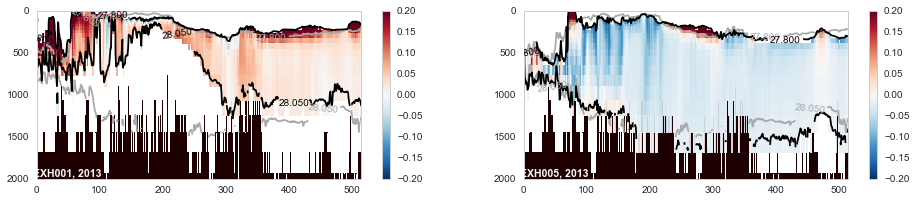

In [47]:
coor=np.linspace(1,len(a),len(a))#x2d[a,b]
iso=[1027.8,1028.05]#1027.8,1028.05]
vlim=[-.2,.2]

#fig,axes=plt.subplots(3,2,figsize=(12,6))
#for i,axnum in zip([2002,2008,2012],range(3)):
for i in range (2002,2014):
        fig,axes=plt.subplots(1,2,figsize=(16,3))
        temp= hov.load_ts('T',T=i,tmask= tmask, ENG='exh001', key = '_t_')
        sal= hov.load_ts('S',T=i,tmask= tmask, ENG='exh001', key = '_s_')
        t = sw.library.T90conv(temp)
        rho = sw.dens0(sal, t)
        

        temp5= hov.load_ts('T',T=i,tmask= tmask, ENG='exh005', key = '_t_')
        sal5= hov.load_ts('S',T=i,tmask= tmask, ENG='exh005', key = '_s_')
        t5 = sw.library.T90conv(temp5)
        rho5 = sw.dens0(sal5, t5)
        if i == 2002:
            base = np.copy(rho)
            base5 = np.copy(rho5)

        for ax,title,rho,rho0 in zip(axes.flat,['EXH001','EXH005'],[rho,rho5],[base,base5]):
            
                mymask = np.copy(rho0[:,a,b])
                data = np.copy(rho0[:,a,b])
                mymask[tmask[:,a,b] == 0] = -1
                ax.pcolor(coor,dep[:],mymask,vmin= -1,cmap= 'pink')                
                data[rho[:,a,b]==0] = np.nan
                ctour=ax.contour(coor,dep[:],np.ma.masked_invalid(data)-1000,np.array(iso)-1000,colors='darkgrey')
                plt.clabel(ctour, inline=1, fontsize=10)
            
            
                mymask = np.copy(rho[:,a,b])
                data = np.copy(rho[:,a,b])
                mymask[tmask[:,a,b] == 0] = -1
                ax.pcolor(coor,dep[:],mymask,vmin= -1,cmap= 'pink')                
                data[rho[:,a,b]==0] = np.nan
                
                ctour=ax.contour(coor,dep[:],np.ma.masked_invalid(data)-1000,np.array(iso)-1000,colors='k')
                plt.clabel(ctour, inline=1, fontsize=10)
                
               
            
                data = np.copy(rho[:,a,b])-rho0[:,a,b]
                mymask[tmask[:,a,b] == 0] = -1
                ax.pcolor(coor,dep[:],mymask,vmin= -1,cmap= 'pink')
                
                
                data[rho[:,a,b]<iso[0]] = np.nan
                data[rho[:,a,b]>iso[1]] = np.nan
                cs=ax.pcolor(coor,dep[:],
                             np.ma.masked_invalid(data),
                             cmap='RdBu_r',vmin = vlim[0],vmax = vlim[1], alpha = 0.9)
                fig.colorbar(cs,ax=ax)
                ax.set_ylim(0,2000)
                ax.set_xlim(0,coor.max())
                ax.invert_yaxis()
                ax.text(0.2,0.02, '%s, %s'%(title,i), transform=ax.transAxes, 
                        weight = 'bold',ha='right', fontsize=10.5,color='white')

                #plt.tight_layout()
        plt.show()


#cax = fig.add_axes([1.01, 0.1, 0.01, 0.8])
#cbar=fig.colorbar(cs,cax=cax,extend='both')#,format='%.0e')
#cbar.formatter.set_powerlimits((-2, 2))
#cbar.update_ticks()
#cbar.set_label('rho')

#plt.tight_layout()
#plt.show()